# Recurrent Neural Network (RNN)
# **Assignment 3**
### 10 Points

---

#### We are using a RNN to predict stock prices in this lab.


1. Build a LSTM net - the architecture should include LSTM layers and Linear layers. [2 points]

2. Define your training process and train the models. You should use Mean Squared Error as your loss function. [2 points]

3. Build a GRU model and repeat the training process for GRU.  [2 points]

4. Fine-tune your models [4 points]
###
##### <span style="color:orange">*You need to save the results and display plots for each round of fine-tuning to show the improvement of your models.* </span>


---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### The data is sourced from https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo/tree/master/StockPricesPredictionProject

Shape of train_X: torch.Size([2276, 1, 240])
Shape of train_Y: torch.Size([2276])
Shape of test_X: torch.Size([2277, 1, 240])
Shape of test_Y: torch.Size([2277])


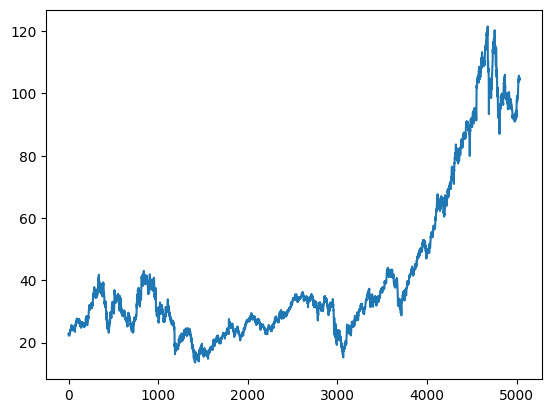

In [2]:
input_file="DIS.csv"
# plot the data
plt.plot(pd.read_csv(input_file, usecols=[1]))
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(5)

# load the dataset
df = read_csv(input_file, header=None, index_col=None, delimiter=',')

# take close price column[5]
all_y = df[5].values
dataset=all_y.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, timestep 240
look_back = 240
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

print('Shape of train_X:', X_train.shape)
print('Shape of train_Y:', y_train.shape)
print('Shape of test_X:', X_test.shape)
print('Shape of test_Y:', y_test.shape)


In [3]:
# (seq, batch, hidden)
X_train= X_train.permute(2,0,1)
X_test= X_test.permute(2,0,1)
print(X_train.shape)
print(X_test.shape)

# (batch, seq, hidden)
X_train= X_train.permute(1,0,2)
X_test= X_test.permute(1,0,2)
print(X_train.shape)
print(X_test.shape)

torch.Size([240, 2276, 1])
torch.Size([240, 2277, 1])
torch.Size([2276, 240, 1])
torch.Size([2277, 240, 1])


### Build a LSTM net - the architecture should include LSTM layers and Linear layers. [2 points]

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(SimpleLSTM, self).__init__()
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # Here x.size(0) refers to the batch size
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # Forward propagate the LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out.squeeze()

### Define your training process and train the models. [2 points]
#### You should use Mean Squared Error as your loss function.
#### Any optimizer of your choice.

In [11]:
from torch.autograd import Variable
# HyperParameters for the model such as input_dim, hidden_dim, learning_rate, epochs etc
"YOUR CODE"

# Hyperparameters
input_dim = 1
hidden_dim = 25
num_layers = 5
output_dim = 1
learning_rate = 0.01
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intialize the model
model = SimpleLSTM(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

model.train()  # Set the model to training mode

for epoch in range(epochs):
    # Clear the gradients
    optimizer.zero_grad()

    # Forward pass: compute the output
    output = model(X_train_var)

    # Compute the loss
    loss = criterion(output, y_train_var)

    # Backward pass: compute the gradient
    loss.backward()

    # Update the weights
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [100/500], Loss: 0.0021227544639259577
Epoch [200/500], Loss: 0.0020090683829039335
Epoch [300/500], Loss: 7.702342554694042e-05
Epoch [400/500], Loss: 5.536323442356661e-05
Epoch [500/500], Loss: 5.512209827429615e-05


#### Your can use the following code to make predictions or you can write your own code.

Text(0.5, 1.0, 'LSTM Model')

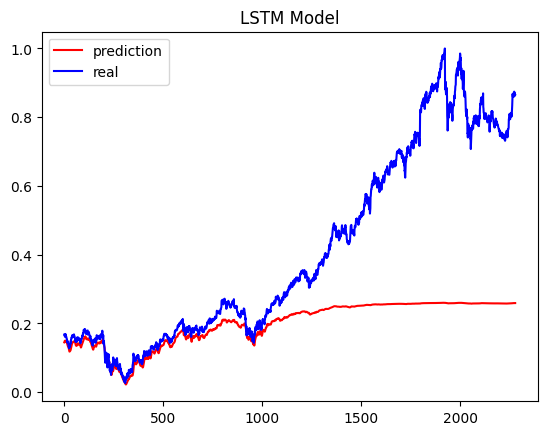

In [12]:
X_test_var = Variable(X_test).to(device)

model.eval()

with torch.no_grad():
    p = model(X_test_var)
    predictions = model(X_test_var).squeeze()  # Forward pass: compute the output

# Convert predictions back to a numpy array
predictions_np = predictions.cpu().numpy()

# Plot the real and predicted values
plt.plot(predictions_np, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.title('LSTM Model')

### Build a GRU model and repeat the training process for GRU.  [2 points]


In [7]:
class SimpleGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(SimpleGRU, self).__init__()
        # Define the GRU layer
        self.gru = nn.GRU(input_size=input_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)

        # Forward propagate the GRU
        out, hn = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out.squeeze()

In [17]:
# Hyperparameters
input_dim = 1
hidden_dim = 25
num_layers = 5
output_dim = 1
learning_rate = 0.01
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model_gru = SimpleGRU(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_gru.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

# Training loop
model_gru.train()

for epoch in range(epochs):
    # Clear the gradients
    optimizer.zero_grad()

    # Forward pass: compute the output
    output_gru = model_gru(X_train_var)

    # Compute the loss
    loss_gru = criterion(output_gru, y_train_var)

    # Backward pass: compute the gradient
    loss_gru.backward()

    # Update the weights
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_gru.item()}')

Epoch [100/500], Loss: 0.00010126231063622981
Epoch [200/500], Loss: 2.6206564143649302e-05
Epoch [300/500], Loss: 2.3351482013822533e-05
Epoch [400/500], Loss: 2.2134907339932397e-05
Epoch [500/500], Loss: 2.1733794710598886e-05



## Predicting GRU Model

Text(0.5, 1.0, 'GRU Model')

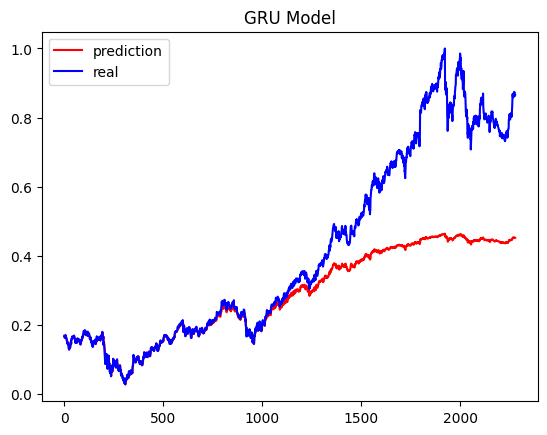

In [18]:
X_test_var = Variable(X_test).to(device)

model_gru.eval()

with torch.no_grad():
    predictions = model_gru(X_test_var).squeeze()  # Forward pass: compute the output

# Convert predictions back to a numpy array
predictions_np = predictions.cpu().numpy()

# Plot the real and predicted values
plt.plot(predictions_np, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.title('GRU Model')

### Fine-tune your models and obtain a prediction plot as following: [4 points]
###
### <span style="color:orange">*You need to save the results and display plots for each round of fine-tuning to show the improvement of your models.* </span>

![image.png](attachment:image.png)

## Change num of hidden layers from 5 to 7 (anymore and gpu runs out of memory)

LSTM Epoch [100/500], LSTM Loss: 0.0021078328136354685
GRU Epoch [100/500], GRU Loss: 0.0020732274278998375

LSTM Epoch [200/500], LSTM Loss: 0.002640426391735673
GRU Epoch [200/500], GRU Loss: 2.756581307039596e-05

LSTM Epoch [300/500], LSTM Loss: 6.479149305960163e-05
GRU Epoch [300/500], GRU Loss: 2.3368913389276713e-05

LSTM Epoch [400/500], LSTM Loss: 3.888440551236272e-05
GRU Epoch [400/500], GRU Loss: 2.2552658265340142e-05

LSTM Epoch [500/500], LSTM Loss: 2.8330692657618783e-05
GRU Epoch [500/500], GRU Loss: 2.2275635274127126e-05



Text(0.5, 1.0, 'LSTM and GRU Models')

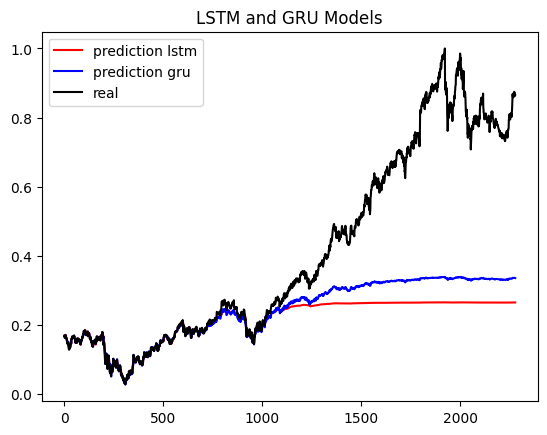

In [22]:
input_dim = 1
hidden_dim = 25
num_layers = 7
output_dim = 1
learning_rate = 0.01
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intialize the model
model_lstm = SimpleLSTM(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)
model_gru = SimpleGRU(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
criterion_gru = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

model.train()  # Set the model to training mode

for epoch in range(epochs):

    # Clear the gradients
    optimizer_lstm.zero_grad()
    optimizer_gru.zero_grad()

    # Forward pass: compute the output
    output_lstm = model_lstm(X_train_var)
    output_gru = model_gru(X_train_var)

    # Compute the loss
    loss_lstm = criterion_lstm(output_lstm, y_train_var)
    loss_gru = criterion_gru(output_gru, y_train_var)

    # Backward pass: compute the gradient
    loss_lstm.backward()
    loss_gru.backward()

    # Update the weights
    optimizer_lstm.step()
    optimizer_gru.step()

    if (epoch+1) % 100 == 0:
        print(f'LSTM Epoch [{epoch+1}/{epochs}], LSTM Loss: {loss_lstm.item()}')
        print(f'GRU Epoch [{epoch+1}/{epochs}], GRU Loss: {loss_gru.item()}\n')

X_test_var = Variable(X_test).to(device)

model_lstm.eval()
model_gru.eval()

with torch.no_grad():
    predictions_lstm = model_lstm(X_test_var).squeeze()
    predictions_gru = model_gru(X_test_var).squeeze()

# Convert predictions back to a numpy array
predictions_lstm_np = predictions_lstm.cpu().numpy()
predictions_gru_np = predictions_gru.cpu().numpy()

# Plot the real and predicted values
plt.plot(y_test, 'black', linestyle='dashed', label='real')
plt.plot(predictions_lstm_np, 'r', label='prediction lstm')
plt.plot(predictions_gru_np, 'b', label='prediction gru')
plt.legend(loc='best')
plt.title('LSTM and GRU Models')

### Change lr from 0.01 to 0.001

LSTM Epoch [100/500], LSTM Loss: 0.0021071911323815584
GRU Epoch [100/500], GRU Loss: 0.00019928609253838658

LSTM Epoch [200/500], LSTM Loss: 0.0002476380323059857
GRU Epoch [200/500], GRU Loss: 8.22368310764432e-05

LSTM Epoch [300/500], LSTM Loss: 0.00014381403161678463
GRU Epoch [300/500], GRU Loss: 6.295795174082741e-05

LSTM Epoch [400/500], LSTM Loss: 0.00012483012687880546
GRU Epoch [400/500], GRU Loss: 5.165803668205626e-05

LSTM Epoch [500/500], LSTM Loss: 0.00010644326539477333
GRU Epoch [500/500], GRU Loss: 4.36126247223001e-05



Text(0.5, 1.0, 'LSTM and GRU Models')

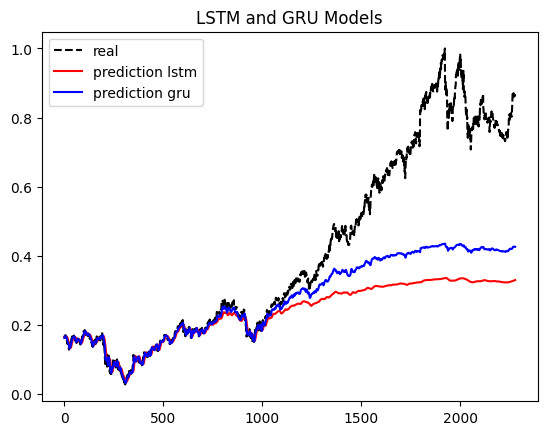

In [31]:
input_dim = 1
hidden_dim = 25
num_layers = 7
output_dim = 1
learning_rate = 0.001
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intialize the model
model_lstm = SimpleLSTM(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)
model_gru = SimpleGRU(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
criterion_gru = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

model.train()  # Set the model to training mode

for epoch in range(epochs):

    # Clear the gradients
    optimizer_lstm.zero_grad()
    optimizer_gru.zero_grad()

    # Forward pass: compute the output
    output_lstm = model_lstm(X_train_var)
    output_gru = model_gru(X_train_var)

    # Compute the loss
    loss_lstm = criterion_lstm(output_lstm, y_train_var)
    loss_gru = criterion_gru(output_gru, y_train_var)

    # Backward pass: compute the gradient
    loss_lstm.backward()
    loss_gru.backward()

    # Update the weights
    optimizer_lstm.step()
    optimizer_gru.step()

    if (epoch+1) % 100 == 0:
        print(f'LSTM Epoch [{epoch+1}/{epochs}], LSTM Loss: {loss_lstm.item()}')
        print(f'GRU Epoch [{epoch+1}/{epochs}], GRU Loss: {loss_gru.item()}\n')

X_test_var = Variable(X_test).to(device)

model_lstm.eval()
model_gru.eval()

with torch.no_grad():
    predictions_lstm = model_lstm(X_test_var).squeeze()
    predictions_gru = model_gru(X_test_var).squeeze()

# Convert predictions back to a numpy array
predictions_lstm_np = predictions_lstm.cpu().numpy()
predictions_gru_np = predictions_gru.cpu().numpy()

# Plot the real and predicted values
plt.plot(y_test, 'black', linestyle='dashed', label='real')
plt.plot(predictions_lstm_np, 'r', label='prediction lstm')
plt.plot(predictions_gru_np, 'b', label='prediction gru')
plt.legend(loc='best')
plt.title('LSTM and GRU Models')

### Change epochs from 500 to 1000

LSTM Epoch [100/1000], LSTM Loss: 0.0021074216347187757
GRU Epoch [100/1000], GRU Loss: 0.0020397768821567297

LSTM Epoch [200/1000], LSTM Loss: 0.0007977961213327944
GRU Epoch [200/1000], GRU Loss: 9.606001549400389e-05

LSTM Epoch [300/1000], LSTM Loss: 0.00014364140224643052
GRU Epoch [300/1000], GRU Loss: 7.361256575677544e-05

LSTM Epoch [400/1000], LSTM Loss: 0.00012200587661936879
GRU Epoch [400/1000], GRU Loss: 6.165817467262968e-05

LSTM Epoch [500/1000], LSTM Loss: 0.00010307286720490083
GRU Epoch [500/1000], GRU Loss: 5.311057611834258e-05

LSTM Epoch [600/1000], LSTM Loss: 8.921916742110625e-05
GRU Epoch [600/1000], GRU Loss: 4.647255627787672e-05

LSTM Epoch [700/1000], LSTM Loss: 8.821224037092179e-05
GRU Epoch [700/1000], GRU Loss: 4.1117204091278836e-05

LSTM Epoch [800/1000], LSTM Loss: 6.743211997672915e-05
GRU Epoch [800/1000], GRU Loss: 3.667885175673291e-05

LSTM Epoch [900/1000], LSTM Loss: 6.607359682675451e-05
GRU Epoch [900/1000], GRU Loss: 3.2949625165201724e-

Text(0.5, 1.0, 'LSTM and GRU Models')

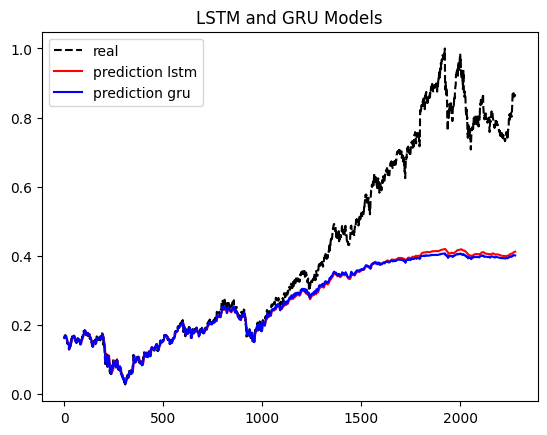

In [32]:
input_dim = 1
hidden_dim = 25
num_layers = 7
output_dim = 1
learning_rate = 0.001
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intialize the model
model_lstm = SimpleLSTM(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)
model_gru = SimpleGRU(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
criterion_gru = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

model.train()  # Set the model to training mode

for epoch in range(epochs):

    # Clear the gradients
    optimizer_lstm.zero_grad()
    optimizer_gru.zero_grad()

    # Forward pass: compute the output
    output_lstm = model_lstm(X_train_var)
    output_gru = model_gru(X_train_var)

    # Compute the loss
    loss_lstm = criterion_lstm(output_lstm, y_train_var)
    loss_gru = criterion_gru(output_gru, y_train_var)

    # Backward pass: compute the gradient
    loss_lstm.backward()
    loss_gru.backward()

    # Update the weights
    optimizer_lstm.step()
    optimizer_gru.step()

    if (epoch+1) % 100 == 0:
        print(f'LSTM Epoch [{epoch+1}/{epochs}], LSTM Loss: {loss_lstm.item()}')
        print(f'GRU Epoch [{epoch+1}/{epochs}], GRU Loss: {loss_gru.item()}\n')

X_test_var = Variable(X_test).to(device)

model_lstm.eval()
model_gru.eval()

with torch.no_grad():
    predictions_lstm = model_lstm(X_test_var).squeeze()
    predictions_gru = model_gru(X_test_var).squeeze()

# Convert predictions back to a numpy array
predictions_lstm_np = predictions_lstm.cpu().numpy()
predictions_gru_np = predictions_gru.cpu().numpy()

# Plot the real and predicted values
plt.plot(y_test, 'black', linestyle='dashed', label='real')
plt.plot(predictions_lstm_np, 'r', label='prediction lstm')
plt.plot(predictions_gru_np, 'b', label='prediction gru')
plt.legend(loc='best')
plt.title('LSTM and GRU Models')

### Increasing epochs, and hidden dimension

LSTM Epoch [500/2000], LSTM Loss: 0.00011142829316668212
GRU Epoch [500/2000], GRU Loss: 2.9789131076540798e-05

LSTM Epoch [1000/2000], LSTM Loss: 7.145942799979821e-05
GRU Epoch [1000/2000], GRU Loss: 2.193434011132922e-05

LSTM Epoch [1500/2000], LSTM Loss: 4.9409951316192746e-05
GRU Epoch [1500/2000], GRU Loss: 2.1714222384616733e-05

LSTM Epoch [2000/2000], LSTM Loss: 3.796489181695506e-05
GRU Epoch [2000/2000], GRU Loss: 2.170964580727741e-05



Text(0.5, 1.0, 'LSTM and GRU Models')

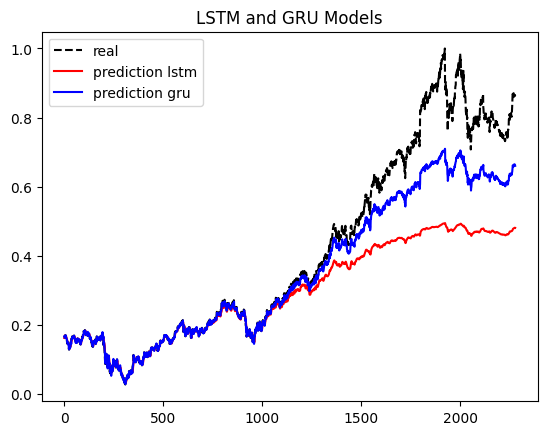

In [40]:
input_dim = 1
hidden_dim = 40
num_layers = 5
output_dim = 1
learning_rate = 0.001
epochs = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intialize the model
model_lstm = SimpleLSTM(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)
model_gru = SimpleGRU(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
criterion_gru = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

model.train()  # Set the model to training mode

for epoch in range(epochs):

    # Clear the gradients
    optimizer_lstm.zero_grad()
    optimizer_gru.zero_grad()

    # Forward pass: compute the output
    output_lstm = model_lstm(X_train_var)
    output_gru = model_gru(X_train_var)

    # Compute the loss
    loss_lstm = criterion_lstm(output_lstm, y_train_var)
    loss_gru = criterion_gru(output_gru, y_train_var)

    # Backward pass: compute the gradient
    loss_lstm.backward()
    loss_gru.backward()

    # Update the weights
    optimizer_lstm.step()
    optimizer_gru.step()

    if (epoch+1) % 500 == 0:
        print(f'LSTM Epoch [{epoch+1}/{epochs}], LSTM Loss: {loss_lstm.item()}')
        print(f'GRU Epoch [{epoch+1}/{epochs}], GRU Loss: {loss_gru.item()}\n')

X_test_var = Variable(X_test).to(device)

model_lstm.eval()
model_gru.eval()

with torch.no_grad():
    predictions_lstm = model_lstm(X_test_var).squeeze()
    predictions_gru = model_gru(X_test_var).squeeze()

# Convert predictions back to a numpy array
predictions_lstm_np = predictions_lstm.cpu().numpy()
predictions_gru_np = predictions_gru.cpu().numpy()

# Plot the real and predicted values
plt.plot(y_test, 'black', linestyle='dashed', label='real')
plt.plot(predictions_lstm_np, 'r', label='prediction lstm')
plt.plot(predictions_gru_np, 'b', label='prediction gru')
plt.legend(loc='best')
plt.title('LSTM and GRU Models')

LSTM Epoch [1000/5000], LSTM Loss: 4.6319863031385466e-05
GRU Epoch [1000/5000], GRU Loss: 2.44165348703973e-05

LSTM Epoch [2000/5000], LSTM Loss: 2.217619476141408e-05
GRU Epoch [2000/5000], GRU Loss: 2.1687799744540825e-05

LSTM Epoch [3000/5000], LSTM Loss: 2.1999701857566833e-05
GRU Epoch [3000/5000], GRU Loss: 2.15412765101064e-05

LSTM Epoch [4000/5000], LSTM Loss: 2.1768712031189352e-05
GRU Epoch [4000/5000], GRU Loss: 2.1510288206627592e-05

LSTM Epoch [5000/5000], LSTM Loss: 2.170596235373523e-05
GRU Epoch [5000/5000], GRU Loss: 2.135179784090724e-05



Text(0.5, 1.0, 'LSTM and GRU Models')

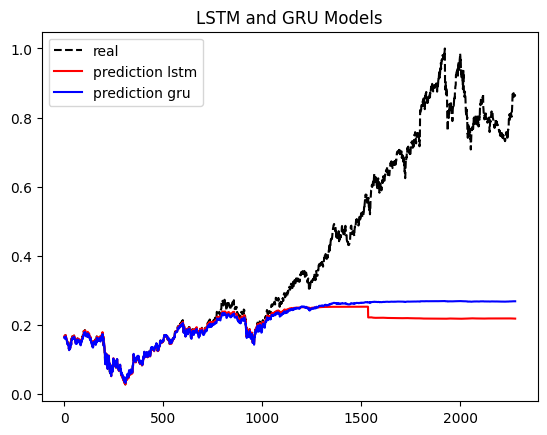

In [41]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1
learning_rate = 0.01
epochs = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intialize the model
model_lstm = SimpleLSTM(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)
model_gru = SimpleGRU(input_dim, hidden_dim, num_layers, output_dim=output_dim).to(device)

# Loss function and optimizer
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
criterion_gru = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

# Convert datasets to PyTorch Variables
X_train_var = Variable(X_train).to(device)
y_train_var = Variable(y_train).to(device)

model.train()  # Set the model to training mode

for epoch in range(epochs):

    # Clear the gradients
    optimizer_lstm.zero_grad()
    optimizer_gru.zero_grad()

    # Forward pass: compute the output
    output_lstm = model_lstm(X_train_var)
    output_gru = model_gru(X_train_var)

    # Compute the loss
    loss_lstm = criterion_lstm(output_lstm, y_train_var)
    loss_gru = criterion_gru(output_gru, y_train_var)

    # Backward pass: compute the gradient
    loss_lstm.backward()
    loss_gru.backward()

    # Update the weights
    optimizer_lstm.step()
    optimizer_gru.step()

    if (epoch+1) % 1000 == 0:
        print(f'LSTM Epoch [{epoch+1}/{epochs}], LSTM Loss: {loss_lstm.item()}')
        print(f'GRU Epoch [{epoch+1}/{epochs}], GRU Loss: {loss_gru.item()}\n')

X_test_var = Variable(X_test).to(device)

model_lstm.eval()
model_gru.eval()

with torch.no_grad():
    predictions_lstm = model_lstm(X_test_var).squeeze()
    predictions_gru = model_gru(X_test_var).squeeze()

# Convert predictions back to a numpy array
predictions_lstm_np = predictions_lstm.cpu().numpy()
predictions_gru_np = predictions_gru.cpu().numpy()

# Plot the real and predicted values
plt.plot(y_test, 'black', linestyle='dashed', label='real')
plt.plot(predictions_lstm_np, 'r', label='prediction lstm')
plt.plot(predictions_gru_np, 'b', label='prediction gru')
plt.legend(loc='best')
plt.title('LSTM and GRU Models')

Performance of reducing learning rate, hidden dimensions, and number of hidden layers reduced performace but took similar time to run - so instead take last hyperparameters and use those as tuned parameters.

Tuned parameters:
input_dim = 1  
hidden_dim = 40   
num_layers = 5   
output_dim = 1    
learning_rate = 0.001  
epochs = 2000